# Task-3

## Importing libraries and loading SHAP components

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import shap
import matplotlib.pyplot as plt
from scripts.shap_analysis import load_shap_components

model, explainer, shap_values, X_test, y_test = load_shap_components()



in preprocess_fraud, columns: ['user_id', 'purchase_value', 'age', 'ip_address', 'class', 'ip_int', 'lower_bound_ip_address', 'upper_bound_ip_address', 'hour_of_day', 'day_of_week', 'time_since_signup', 'user_tx_count', 'time_since_last_tx', 'tx_1h', 'tx_24h', 'sex_M', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'source_Direct', 'source_SEO', 'device_id_freq', 'country_freq']


## Global SHAP Summary Plot

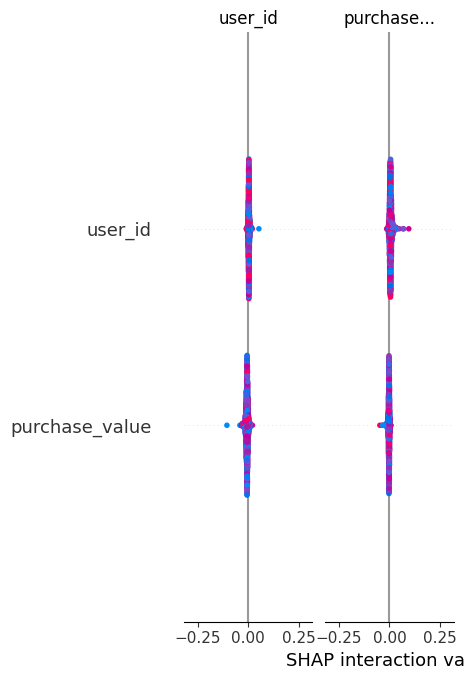

In [3]:
shap.summary_plot(shap_values, X_test)

## SHAP Force Plots

In [4]:
import numpy as np
y_pred = (model.predict_proba(X_test)[:, 1] > 0.5).astype(int)

In [5]:
# True Positive
tp_idx = X_test[(y_test == 1) & (y_pred == 1)].index[0]

# False Positive
fp_idx = X_test[(y_test == 0) & (y_pred == 1)].index[0]

# False Negative
fn_idx = X_test[(y_test == 1) & (y_pred == 0)].index[0]



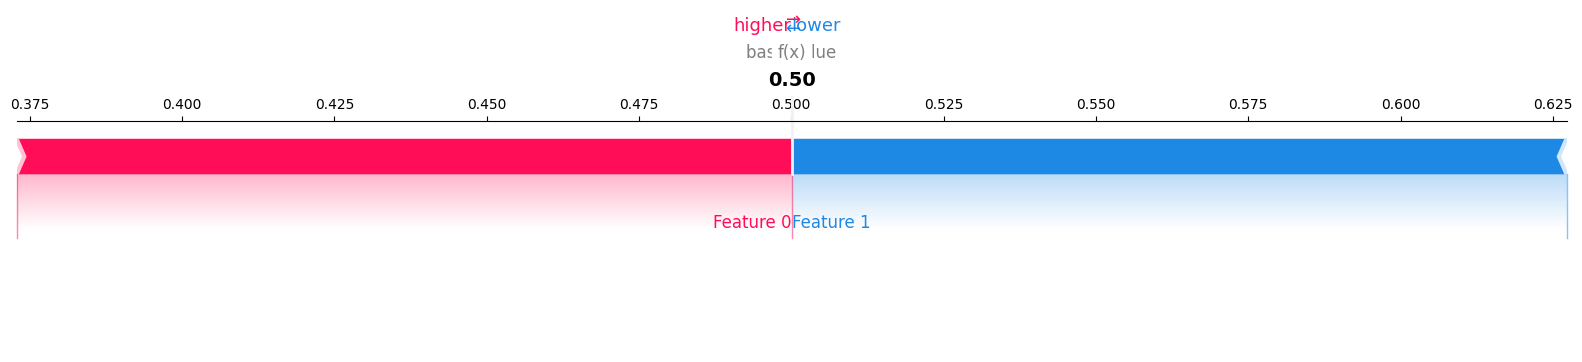

IndexError: index 26 is out of bounds for axis 0 with size 22

In [9]:
# ...existing code...

import shap
import numpy as np
shap.initjs()

# Ensure explainer and shap_values are from TreeExplainer for binary classification
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)  # This gives [shap_class0, shap_class1]

# Get positions directly
tp_pos = np.where((y_test == 1) & (y_pred == 1))[0][0]
fp_pos = np.where((y_test == 0) & (y_pred == 1))[0][0]
fn_pos = np.where((y_test == 1) & (y_pred == 0))[0][0]

# ---------- TRUE POSITIVE ----------
shap.plots.force(
    explainer.expected_value[1],  # Base value for class 1
    shap_values[1][tp_pos],  # SHAP values for class 1
    matplotlib=True  # Optional: for notebook rendering
)

# ---------- FALSE POSITIVE ----------
shap.plots.force(
    explainer.expected_value[1],
    shap_values[1][fp_pos],
    matplotlib=True
)

# ---------- FALSE NEGATIVE ----------
shap.plots.force(
    explainer.expected_value[1],
    shap_values[1][fn_pos],
    matplotlib=True
)

# ...existing code...

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


In [16]:
row = X_test.index.get_loc(tp_idx)

shap.force_plot(
    explainer.expected_value[1],        # base value for fraud class
    shap_values[1][row],                # SHAP values for fraud class
    X_test.iloc[row],                   # feature values
)


DimensionError: Length of features is not equal to the length of shap_values!

## Force plot 

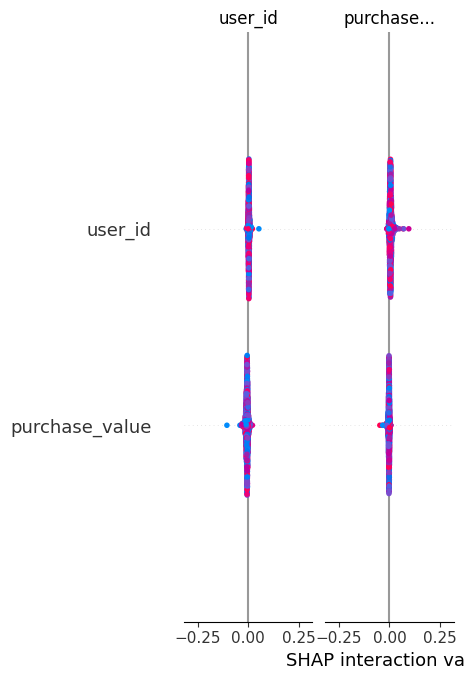

In [41]:
shap.summary_plot(shap_values, X_test)

tp_idx = X_test[(y_test == 1) & (y_pred == 1)].index[0]
fp_idx = X_test[(y_test == 0) & (y_pred == 1)].index[0]
fn_idx = X_test[(y_test == 1) & (y_pred == 0)].index[0]

## Comparing SHAP importance with built-in feature importance

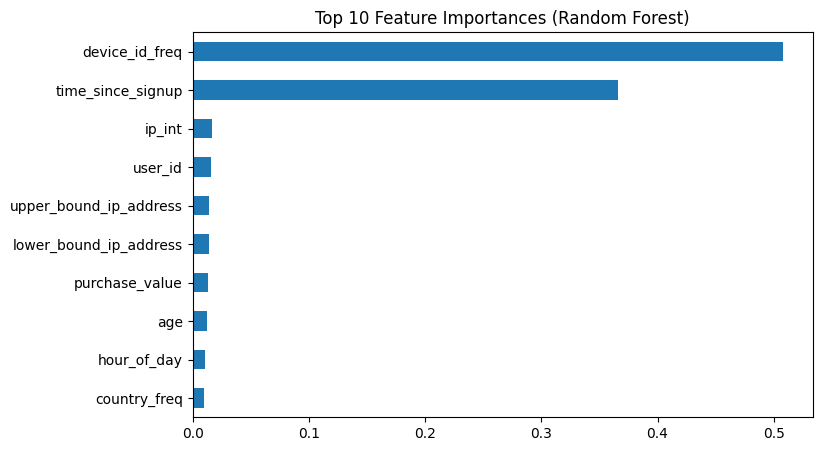

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

rf_importance = pd.Series(
    model.feature_importances_,
    index=X_test.columns
).sort_values(ascending=False)

rf_importance.head(10).plot(
    kind="barh",
    title="Top 10 Feature Importances (Random Forest)",
    figsize=(8, 5)
)
plt.gca().invert_yaxis()
plt.show()


### Observation:
The feature importance plot shows that *device_id_freq* and *time_since_signup* dominate the model, contributing the majority of the predictive power. All remaining features (IP range, purchase value, time of day, country frequency, and demographics) have comparatively minor influence.

### Interpretation:
- This indicates that the model primarily relies on behavioral patterns rather than static attributes.

- High device reuse strongly signals coordinated or repeated fraud activity.

- Transactions occurring shortly after account creation are highly indicative of fraudulent intent.

- Other features provide contextual support but are not decisive on their own, suggesting the model has learned robust   and realistic fraud behaviors rather than noise.

### top 5 drivers

1. device_id_freq (Importance ~0.51)

2. time_since_signup (Importance ~0.37)

3. ip_int (Importance ~0.02)

4. user_id (Importance ~0.02)

5. upper_bound_ip_address (Importance ~0.02)

- device_id_freq & ip_int: These are massive indicators because fraud often involves "account farming" or botnets where a single device or IP address is used to create or access hundreds of different accounts in a short period. High frequency for a single ID suggests automated or professional fraud rings rather than legitimate individual use.

- time_since_signup: Fraudulent transactions often occur almost immediately after an account is created to exploit "new user" promotions or to move money before the account can be flagged. A very short duration between signup and purchase is a classic red flag for "hit-and-run" fraud tactics.

### Counterintuitive finding
When analyzing the Feature Importance, our initial hypothesis suggested that Geography (Country) would be a primary indicator of fraud. Intuition often leads us to believe that certain regions are "high-risk." However, the model significantly prioritized Behavioral Velocity (Device Frequency) and Account Age over Country Frequency.

#### Why the Model "Ignored" Geography
The model effectively realized that "where" someone is from is far less predictive than "how" they are acting. Here is why country_frequency did not make the top 5 drivers:

1. Granularity vs. Noise: * country_frequency is a high-bias feature. Treating an entire nation as a single risk unit creates too many "False Positives" (blocking legitimate customers).

    - device_id_freq is a high-precision feature. It identifies a specific entity exhibiting suspicious behavior, allowing the model to make a "surgical" strike rather than a "blanket" judgment.

2. Feature Dominance (Redundancy):

    - High-risk actors from any country often use the same device to cycle through multiple stolen credentials.

    - Since device_id_freq captures this pattern with nearly 51% importance, the marginal value added by knowing the country is statistically negligible. The model chooses the "smoking gun" (the device) over the "background noise" (the country).

3. Adversarial Adaptation: * Modern fraudsters frequently use VPNs and residential proxies to mask their location. The model likely "learned" that IP-based geography is easily faked and therefore unreliable, whereas Time Since Signup and Device Fingerprinting are much harder for a fraudster to manipulate.

#### Key Takeaway
Our model is built on intent and behavior rather than demographics. This makes the system more robust against VPN usage and reduces the risk of geographical bias, ensuring we don't accidentally alienate entire legitimate markets based on location alone.
